In [1]:
from __future__ import division

import random
import math
import copy
import os
import pickle

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from lentil import datatools
from lentil import datasynth
from lentil import evaluate
from lentil import models
from lentil import est

%matplotlib inline

In [2]:
import logging
logging.getLogger().setLevel(logging.DEBUG)

Generate a synthetic 1PL/2PL IRT model and sample an interaction history from it

In [3]:
num_students = 2000
num_assessments = 3000
num_ixns_per_student = 1000

USING_2PL = False # False => using 1PL

In [4]:
proficiencies = np.random.normal(0, 1, num_students)
difficulties = np.random.normal(0, 1, num_assessments)

if USING_2PL:
    discriminabilities = np.random.normal(0, 1, num_assessments)
else:
    discriminabilities = np.ones(num_assessments)

user_ids = ['S'+str(x) for x in range(num_students)]
assessment_ids = ['A'+str(x) for x in range(num_assessments)]

In [5]:
ixns = [None] * (num_students * num_ixns_per_student)
assessment_idxes = range(num_assessments)
for user_idx, user_id in enumerate(user_ids):
    for t in range(num_ixns_per_student):
        module_idx = random.choice(assessment_idxes)
        pass_likelihood = 1 / (1 + math.exp(-(discriminabilities[module_idx]*proficiencies[user_idx] + difficulties[module_idx])))
        ixns[user_idx * num_ixns_per_student + t] = {
            'user_id' : user_id, 
            'module_id' : assessment_ids[module_idx], 
            'module_type' : datatools.AssessmentInteraction.MODULETYPE,
            'outcome' : np.random.random() < pass_likelihood, 
            'timestep' : t+1
        }
history = datatools.InteractionHistory(pd.DataFrame(ixns))
history.idx_of_user_id = lambda x: int(x[1:])
history.idx_of_assessment_id = lambda x: int(x[1:])

In [6]:
mirt_model = models.MIRTModel(history, dims=1, using_assessment_factors=USING_2PL)
estimator = est.MIRTMAPEstimator(
    regularization_constant=1e-3,
    ftol=1e-5,
    debug_mode_on=True)
mirt_model.fit(estimator)

In [7]:
onepl_model = models.OneParameterLogisticModel(
    history.data, select_regularization_constant=True)
onepl_model.fit()

/home/zvonimir/PycharmProjects/lentil/venv/local/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2178: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/zvonimir/PycharmProjects/lentil/venv/local/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [8]:
twopl_model = models.TwoParameterLogisticModel(
    history.data, select_regularization_constant=True)
twopl_model.fit()

In [9]:
user_idxes = [int(k[1:]) for k in history.data['user_id'].unique()]
assessment_idxes = [int(k[1:]) for k in history.data['module_id'].unique()]

Verify that `models.OneParameterLogisticModel` can recover parameters. We would only expect this to be possible when `USING_2PL = False`.

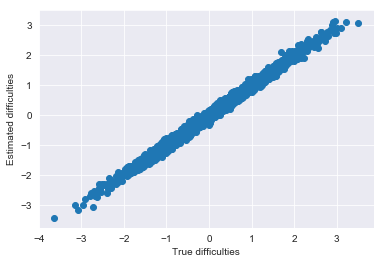

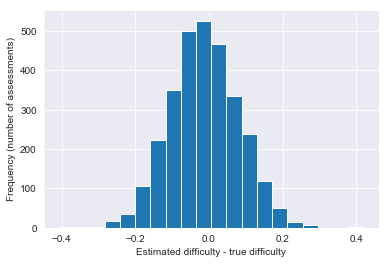

In [10]:
plt.xlabel('True difficulties')
plt.ylabel('Estimated difficulties')
plt.scatter(difficulties[assessment_idxes], onepl_model.model.coef_[0, num_students:])
plt.show()

plt.xlabel('Estimated difficulty - true difficulty')
plt.ylabel('Frequency (number of assessments)')
plt.hist(onepl_model.model.coef_[0, num_students:] - difficulties[assessment_idxes], bins=20)
plt.show()

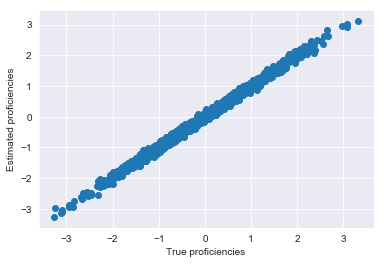

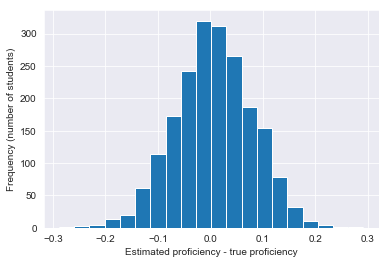

In [11]:
plt.xlabel('True proficiencies')
plt.ylabel('Estimated proficiencies')
plt.scatter(proficiencies[user_idxes], onepl_model.model.coef_[0, :num_students])
plt.show()

plt.xlabel('Estimated proficiency - true proficiency')
plt.ylabel('Frequency (number of students)')
plt.hist(onepl_model.model.coef_[0, :num_students] - proficiencies[user_idxes], bins=20)
plt.show()

Verify that `models.TwoParameterLogisticModel` can recover parameters. We would only expect this to be possible when `USING_2PL = True`.

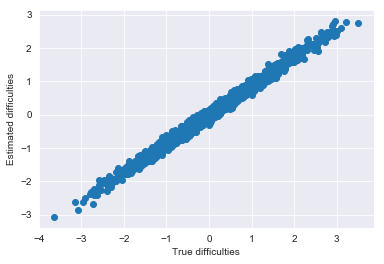

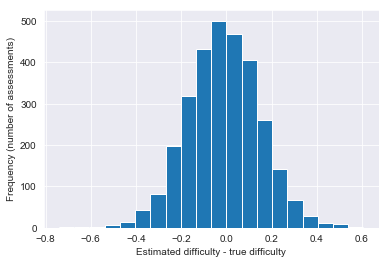

In [12]:
plt.xlabel('True difficulties')
plt.ylabel('Estimated difficulties')
plt.scatter(difficulties[assessment_idxes], twopl_model.model.coef_[0, (num_students*num_assessments):])
plt.show()

plt.xlabel('Estimated difficulty - true difficulty')
plt.ylabel('Frequency (number of assessments)')
plt.hist(twopl_model.model.coef_[0, (num_students*num_assessments):] - difficulties[assessment_idxes], bins=20)
plt.show()

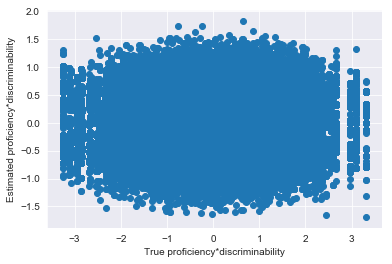

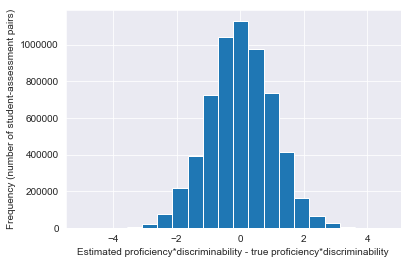

In [13]:
est_params = twopl_model.model.coef_[0, :(num_students*num_assessments)]
true_params = discriminabilities[:, None].dot(proficiencies[:, None].T).ravel()

plt.xlabel('True proficiency*discriminability')
plt.ylabel('Estimated proficiency*discriminability')
plt.scatter(true_params, est_params)
plt.show()

plt.xlabel('Estimated proficiency*discriminability - true proficiency*discriminability')
plt.ylabel('Frequency (number of student-assessment pairs)')
plt.hist(est_params - true_params, bins=20)
plt.show()

Verify that `models.MIRTModel` can recover parameters

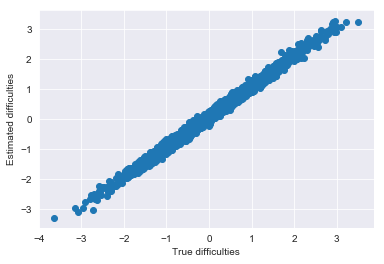

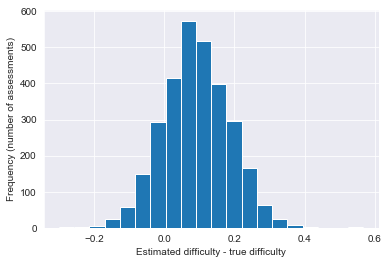

In [14]:
plt.xlabel('True difficulties')
plt.ylabel('Estimated difficulties')
plt.scatter(difficulties, mirt_model.assessment_offsets)
plt.show()

plt.xlabel('Estimated difficulty - true difficulty')
plt.ylabel('Frequency (number of assessments)')
plt.hist(mirt_model.assessment_offsets - difficulties, bins=20)
plt.show()

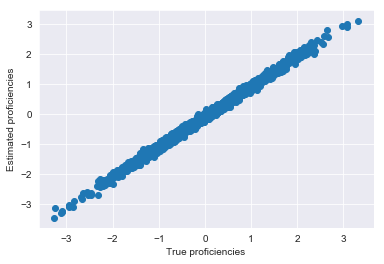

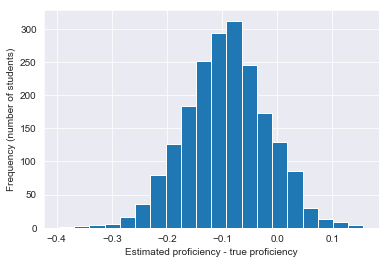

In [15]:
plt.xlabel('True proficiencies')
plt.ylabel('Estimated proficiencies')
plt.scatter(proficiencies, mirt_model.student_factors[:, 0])
plt.show()

plt.xlabel('Estimated proficiency - true proficiency')
plt.ylabel('Frequency (number of students)')
plt.hist(mirt_model.student_factors[:, 0] - proficiencies, bins=20)
plt.show()

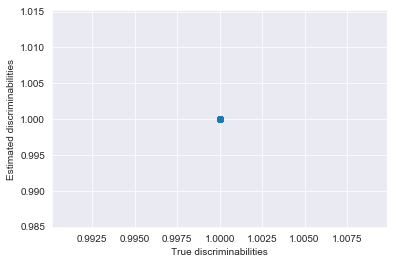

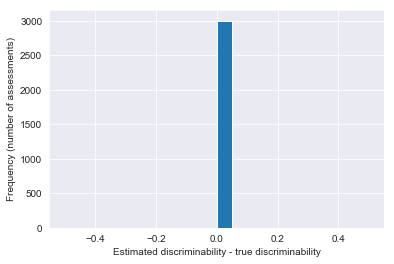

In [16]:
plt.xlabel('True discriminabilities')
plt.ylabel('Estimated discriminabilities')
plt.scatter(discriminabilities, mirt_model.assessment_factors[:, 0])
plt.show()

plt.xlabel('Estimated discriminability - true discriminability')
plt.ylabel('Frequency (number of assessments)')
plt.hist(mirt_model.assessment_factors[:, 0] - discriminabilities, bins=20)
plt.show()

Verify that all models achieve similar training AUCs

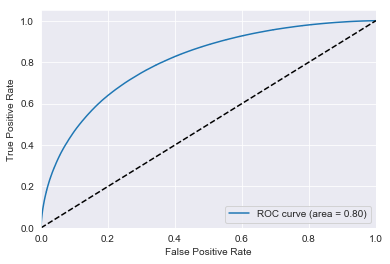

0.8018053962090208

In [17]:
# models.OneParameterLogisticModel
evaluate.training_auc(onepl_model, history, plot_roc_curve=True)

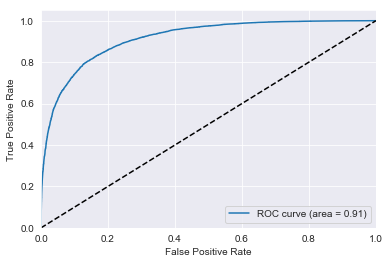

0.9149182486610453

In [18]:
# models.TwoParameterLogisticModel
evaluate.training_auc(twopl_model, history, plot_roc_curve=True)

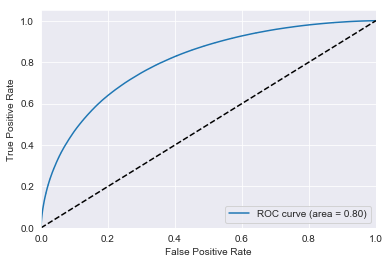

0.8018060080815321

In [19]:
# models.MIRTModel
evaluate.training_auc(mirt_model, history, plot_roc_curve=True)

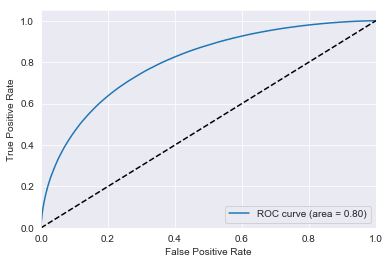

0.8006903103084825

In [20]:
# true model
true_model = copy.deepcopy(mirt_model)
true_model.student_factors[:, 0] = proficiencies
true_model.assessment_factors[:, 0] = discriminabilities
true_model.assessment_offsets = difficulties
evaluate.training_auc(true_model, history, plot_roc_curve=True)

Construct a synthetic embedding

In [21]:
num_students = 10000
num_assessment_interactions_per_step = 100
grid_size = 5
embedding_dimension = 2

num_assessments = grid_size ** 2
num_lessons = 2 * grid_size * (grid_size - 1)
num_lesson_interactions_per_student = 2 * (grid_size - 1) + 2

In [22]:
S = np.zeros((num_students, embedding_dimension, num_lesson_interactions_per_student))
A = np.zeros((num_assessments, embedding_dimension))
L = np.zeros((num_lessons, embedding_dimension))
Q = np.zeros((num_lessons, embedding_dimension))

lesson_idx_of_loc = {}
assessment_idx_of_loc = {}

cell_size = 10 / (grid_size - 1)
lesson_count = 0
for i in range(grid_size):
    for j in range(grid_size):
        A[grid_size * i + j, :] = [i, j]
        assessment_idx_of_loc[(i, j)] = grid_size * i + j
        
        if j < grid_size - 1:
            Q[lesson_count, :] = [i, j]
            L[lesson_count, :] = [0, 1]
            lesson_idx_of_loc[(i, j, 0, 1)] = lesson_count
            lesson_count += 1
        
        if i < grid_size - 1:
            Q[lesson_count, :] = [i, j]
            L[lesson_count, :] = [1, 0]
            lesson_idx_of_loc[(i, j, 1, 0)] = lesson_count
            lesson_count += 1
            
A *= cell_size
Q *= cell_size
L *= cell_size

A = np.maximum(1e-3, A)
Q = np.maximum(1e-3, Q)

In [23]:
lesson_loc_of_idx = {v: k for k, v in lesson_idx_of_loc.iteritems()}
assessment_loc_of_idx = {v: k for k, v in assessment_idx_of_loc.iteritems()}

Sample interactions from the synthetic embedding

In [24]:
id_of_loc = lambda x: '-'.join(str(z) for z in x)

In [25]:
data = []
for user_idx in range(num_students):
    user_id = 'S' + str(user_idx)
    steps = ([(0, 1)] * (grid_size - 1)) +  ([(1, 0)] * (grid_size - 1))
    random.shuffle(steps)
    
    x, y = 0, 0
    t = 1
    assessment_idx = assessment_idx_of_loc[(0, 0)]
    assessment_id = id_of_loc(assessment_loc_of_idx[assessment_idx])
    pass_likelihood = 1 / (1 + math.exp(-(np.dot(S[user_idx, :, t], A[assessment_idx, :]) / np.linalg.norm(A[assessment_idx, :]) - np.linalg.norm(A[assessment_idx, :]))))
    outcome = random.random() < pass_likelihood
    data.append({
        'user_id' : user_id, 
        'module_id' : assessment_id,
        'module_type' : datatools.AssessmentInteraction.MODULETYPE,
        'timestep' : t,
        'outcome' : outcome})
    
    for i, j in steps:
        lesson_idx = lesson_idx_of_loc[(x, y, i, j)]
        lesson_id = id_of_loc(lesson_loc_of_idx[lesson_idx])
        data.append({
            'user_id' : user_id,
            'module_id' : lesson_id,
            'module_type' : datatools.LessonInteraction.MODULETYPE,
            'timestep' : t, 
            'outcome' : None})
        
        x += i
        y += j
        # DEBUG
        S[user_idx, :, t+1] = S[user_idx, :, t] + L[lesson_idx, :]# / (1 + math.exp(-(np.dot(S[user_idx, :, t], Q[lesson_idx, :]) / np.linalg.norm(Q[lesson_idx, :]) - np.linalg.norm(Q[lesson_idx, :]))))
        
        t += 1
        for _ in range(num_assessment_interactions_per_step):
            assessment_idx = random.randint(0, num_assessments - 1)
            assessment_id = id_of_loc(assessment_loc_of_idx[assessment_idx])
            pass_likelihood = 1 / (1 + math.exp(-(np.dot(S[user_idx, :, t], A[assessment_idx, :]) / np.linalg.norm(A[assessment_idx, :]) - np.linalg.norm(A[assessment_idx, :]))))
            outcome = random.random() < pass_likelihood
            # BEGIN DEBUG
            if assessment_idx_of_loc[(0, 0)] == assessment_idx:
                outcome = random.random() < 0.1
            # END DEBUG
            data.append({
                'user_id' : user_id,
                'module_id' : assessment_id,
                'module_type' : datatools.AssessmentInteraction.MODULETYPE,
                'timestep' : t,
                'outcome' : outcome})

In [26]:
history = datatools.InteractionHistory(pd.DataFrame(data))

assessment_idx_map = {id_of_loc(loc): idx for idx, loc in assessment_loc_of_idx.iteritems()}
lesson_idx_map = {id_of_loc(loc): idx for idx, loc in lesson_loc_of_idx.iteritems()}
history.compute_idx_maps(assessment_idx=assessment_idx_map, lesson_idx=lesson_idx_map)

In [27]:
len(history.data)

8090000

In [28]:
history_path = os.path.join('data', 'lse_synthetic_history.pkl')

In [29]:
with open(history_path, 'wb') as f:
    pickle.dump(history, f, pickle.HIGHEST_PROTOCOL)

IOError: [Errno 2] No such file or directory: 'data/lse_synthetic_history.pkl'

Estimate an embedding from the sampled interactions

In [ ]:
model = models.EmbeddingModel(
    history, embedding_dimension=2, 
    using_lessons=True, using_prereqs=False, using_bias=True, 
    learning_update_variance_constant=0.5)

estimator = est.EmbeddingMAPEstimator(
    regularization_constant=1e-3, using_scipy=True, 
    debug_mode_on=True, ftol=1e-4)

model.fit(estimator)

In [ ]:
model = models.OneParameterLogisticModel(history.data, select_regularization_constant=True)
model.fit()

In [ ]:
evaluate.training_auc(model, history, plot_roc_curve=True)

Visualize the estimated embedding vs. the true embedding

In [ ]:
plt.scatter(A[:, 0], A[:, 1])
for assessment_idx in range(num_assessments):
    plt.annotate(id_of_assessment_idx(assessment_idx), (A[assessment_idx, 0], A[assessment_idx, 1]))
"""
for i in range(grid_size):
    for j in range(grid_size):
        if j < grid_size - 1:
            assessment_idxes = [assessment_idx_of_loc[(i, j)], assessment_idx_of_loc[(i, j + 1)]]
            plt.plot(A[assessment_idxes, 0], A[assessment_idxes, 1], c='black')
            
        if i < grid_size - 1:
            assessment_idxes = [assessment_idx_of_loc[(i, j)], assessment_idx_of_loc[(i + 1, j)]]
            plt.plot(A[assessment_idxes, 0], A[assessment_idxes, 1], c='black')
"""
plt.show()

In [ ]:
plt.scatter(model.assessment_embeddings[:, 0], model.assessment_embeddings[:, 1])
for assessment_idx in range(num_assessments):
    plt.annotate(id_of_assessment_idx(assessment_idx), (model.assessment_embeddings[assessment_idx, 0], model.assessment_embeddings[assessment_idx, 1]))
"""
for i in range(grid_size):
    for j in range(grid_size):
        if j < grid_size - 1:
            assessment_idxes = [assessment_idx_of_loc[(i, j)], assessment_idx_of_loc[(i, j + 1)]]
            plt.plot(model.assessment_embeddings[assessment_idxes, 0], model.assessment_embeddings[assessment_idxes, 1], c='black')
            
        if i < grid_size - 1:
            assessment_idxes = [assessment_idx_of_loc[(i, j)], assessment_idx_of_loc[(i + 1, j)]]
            plt.plot(model.assessment_embeddings[assessment_idxes, 0], model.assessment_embeddings[assessment_idxes, 1], c='black')
"""
plt.show()

In [ ]:
plt.quiver(Q[:, 0], Q[:, 1], L[:, 0], L[:, 1], pivot='tail', color='black')
"""
for i in range(grid_size):
    for j in range(grid_size):
        if j < grid_size - 1:
            lesson_idxes = [lesson_idx_of_loc[(i, j)], lesson_idx_of_loc[(i, j + 1)]]
            plt.plot(Q[lesson_idxes, 0], Q[lesson_idxes, 1], c='black')
            
        if i < grid_size - 1:
            lesson_idxes = [lesson_idx_of_loc[(i, j)], lesson_idx_of_loc[(i + 1, j)]]
            plt.plot(Q[lesson_idxes, 0], Q[lesson_idxes, 1], c='black')
"""
plt.xlabel('Skill 1')
plt.ylabel('Skill 2')
plt.xlim([-1, 11])
plt.ylim([-1, 11])
plt.show()

In [ ]:
plt.quiver(model.prereq_embeddings[:, 0], model.prereq_embeddings[:, 1], model.lesson_embeddings[:, 0], model.lesson_embeddings[:, 1], pivot='tail', color='black')
"""
for i in range(grid_size):
    for j in range(grid_size):
        if j < grid_size - 1:
            lesson_idxes = [lesson_idx_of_loc[(i, j)], lesson_idx_of_loc[(i, j + 1)]]
            plt.plot(model.prereq_embeddings[lesson_idxes, 0], model.prereq_embeddings[lesson_idxes, 1], c='black')
            
        if i < grid_size - 1:
            lesson_idxes = [lesson_idx_of_loc[(i, j)], lesson_idx_of_loc[(i + 1, j)]]
            plt.plot(model.prereq_embeddings[lesson_idxes, 0], model.prereq_embeddings[lesson_idxes, 1], c='black')
"""
plt.xlabel('Skill 1')
plt.ylabel('Skill 2')
plt.xlim([-1, 11])
plt.ylim([-1, 11])
plt.show()

In [ ]:
right_lesson_idxes = [lesson_idx_of_loc[(i, j, 1, 0)] for i in range(grid_size) for j in range(grid_size) if (i, j, 1, 0) in lesson_idx_of_loc]
up_lesson_idxes = [lesson_idx_of_loc[(i, j, 0, 1)] for i in range(grid_size) for j in range(grid_size) if (i, j, 0, 1) in lesson_idx_of_loc]

In [ ]:
plt.quiver(0, 0, L[right_lesson_idxes, 0], L[right_lesson_idxes, 1], pivot='tail', color='red', alpha=0.25)
plt.quiver(0, 0, L[up_lesson_idxes, 0], L[up_lesson_idxes, 1], pivot='tail', color='blue', alpha=0.25)

plt.xlabel('Skill 1')
plt.ylabel('Skill 2')
plt.xlim([-1, 11])
plt.ylim([-1, 11])
plt.show()

In [ ]:
plt.quiver(0, 0, model.lesson_embeddings[right_lesson_idxes, 0], model.lesson_embeddings[right_lesson_idxes, 1], pivot='tail', color='red', alpha=0.25)
plt.quiver(0, 0, model.lesson_embeddings[up_lesson_idxes, 0], model.lesson_embeddings[up_lesson_idxes, 1], pivot='tail', color='blue', alpha=0.25)

plt.xlabel('Skill 1')
plt.ylabel('Skill 2')
plt.xlim([-1, 11])
plt.ylim([-1, 11])
plt.show()

In [ ]:
plt.scatter(L[right_lesson_idxes, 0], L[right_lesson_idxes, 1], color='red', label='1-0')
plt.scatter(L[up_lesson_idxes, 0], L[up_lesson_idxes, 1], color='blue', label='0-1')
plt.xlabel('Skill 1')
plt.ylabel('Skill 2')
plt.legend(loc='best')
plt.show()

In [ ]:
plt.scatter(model.lesson_embeddings[right_lesson_idxes, 0], model.lesson_embeddings[right_lesson_idxes, 1], color='red', label='1-0')
plt.scatter(model.lesson_embeddings[up_lesson_idxes, 0], model.lesson_embeddings[up_lesson_idxes, 1], color='blue', label='0-1')
plt.xlabel('Skill 1')
plt.ylabel('Skill 2')
plt.legend(loc='best')
plt.show()

In [ ]:
user_idxes = random.sample(range(num_students), 10)

In [ ]:
for user_idx in user_idxes:
    plt.scatter(S[user_idx, 0, :], S[user_idx, 1, :], c='black')
    for i in range(num_lesson_interactions_per_student):
        plt.plot(S[user_idx, 0, i:(i+2)], S[user_idx, 1, i:(i+2)], c='black')
    plt.xlabel('Skill 1')
    plt.ylabel('Skill 2')
    plt.title('user_id = %s' % history.id_of_user_idx(user_idx))
    plt.show()

In [ ]:
for user_idx in user_idxes:
    plt.scatter(model.student_embeddings[user_idx, 0, :], model.student_embeddings[user_idx, 1, :], c='black')
    for i in range(num_lesson_interactions_per_student):
        plt.plot(model.student_embeddings[user_idx, 0, i:(i+2)], model.student_embeddings[user_idx, 1, i:(i+2)], c='black')
    plt.xlabel('Skill 1')
    plt.ylabel('Skill 2')
    plt.title('user_id = %s' % history.id_of_user_idx(user_idx))
    plt.show()

In [ ]:
for user_idx in user_idxes:
    for i in range(embedding_dimension):
        plt.plot(S[user_idx, i, :], '-s', label='Skill 1')
    plt.xlabel('timestep')
    plt.ylabel('Skill')
    plt.title('user_id = %s' % history.id_of_user_idx(user_idx))
    plt.legend(loc='best')
    plt.show()

In [ ]:
for user_idx in user_idxes:
    for i in range(embedding_dimension):
        plt.plot(model.student_embeddings[user_idx, i, :], '-s', label='Skill 1')
    plt.xlabel('timestep')
    plt.ylabel('Skill')
    plt.title('user_id = %s' % history.id_of_user_idx(user_idx))
    plt.legend(loc='best')
    plt.show()